In [2]:
from csv import reader
import numpy as np
import plotly.graph_objects as go

In [4]:
def plot(*args):
    plts=[]
    for it in args:
        data = np.array(list(it))
        plts.append(dict(x=data[:,0], y=data[:,1]))
    go.Figure(plts).show()

In [6]:
def get_data():
    with open('temperatures.csv') as f:
        r = reader(f)
        starty = 1821
        for row in r:
            [y,m,t]=row
            if float(t) >= 999: continue
            d = (int(y)-starty)*12+int(m)
            yield((d,float(t)))

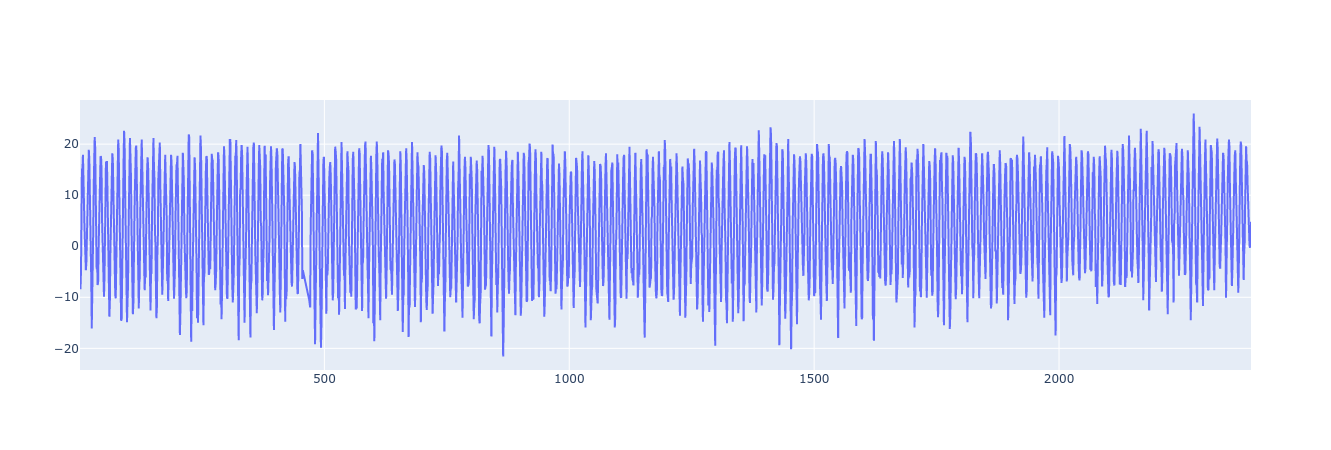

In [8]:
plot(get_data())

In [10]:
def jumping_window(it, window):
    xacc = 0
    yacc = 0
    cntr = 0
    for (x,y) in it:
        xacc += x
        yacc += y
        cntr += 1
        if cntr == window:
            yield ((xacc/window, yacc/window))
            xacc = 0
            yacc = 0
            cntr = 0

In [16]:
import ipywidgets as w
from ipywidgets import interact
@interact(window=w.IntSlider(min=1, max=12*10))
def jw_interact(window):
    plot(jumping_window(get_data(), window))

interactive(children=(IntSlider(value=1, description='window', max=120, min=1), Output()), _dom_classes=('widg…

In [20]:
from itertools import cycle, islice
def moving_window(it, window, weights=[1]):
    acc = []
    wws = list(islice(cycle(weights), window))
    sw = sum(wws)
    for (x,y) in it:
        acc.append((x,y))
        if len(acc) == window:
            vs = list(zip(acc,wws))
            xmean = sum([x*w for ((x,y),w) in vs])/sw
            ymean = sum([y*w for ((x,y),w) in vs])/sw
            yield((xmean, ymean))
            acc.pop(0)

In [22]:
@interact(window=w.IntSlider(min=1, max=12*10))
def jw_interact(window):
    plot(moving_window(get_data(), window))

interactive(children=(IntSlider(value=1, description='window', max=120, min=1), Output()), _dom_classes=('widg…

In [28]:
import statistics as stat
def y(it):
    return (y for (x,y) in it)
print('mean', stat.mean(y(get_data())))
print('median', stat.median(y(get_data())))
print('stddev', stat.stdev(y(get_data())))
print('variance', stat.variance(y(get_data())))

mean 4.40390756302521
median 4.65
stddev 10.39138772767923
variance 107.98093890696254


In [30]:
import random
def reservoir(it, n):
    reservoir = []
    for t, item in enumerate(it):
        if len(reservoir) < n:
            reservoir.append(item)
        else:
            m = random.randint(0,t)
            if m < n:
                yield reservoir[m]
                reservoir[m] = item

In [72]:
@interact(n=w.IntSlider(min=32,max=256))
def rs_interact(n):
    print('reservoir len', len(list(reservoir(get_data(),n))))
    print('mean', stat.mean(y(reservoir(get_data(),n))))
    print('median', stat.median(y(reservoir(get_data(),n))))
    print('stddev', stat.stdev(y(reservoir(get_data(),n))))
    print('variance', stat.variance(y(reservoir(get_data(),n))))

interactive(children=(IntSlider(value=32, description='n', max=256, min=32), Output()), _dom_classes=('widget-…

In [83]:
from hyperloglog import HyperLogLog
@interact(e=w.FloatSlider(min=0.01, max=0.05,step=0.01))
def hll_interact(e):
    hll = HyperLogLog(error_rate=e)

    for i in y(get_data()):
        hll.add(str(i))

    print('hll', hll.card())
    print('real', len(set(y(get_data()))))

interactive(children=(FloatSlider(value=0.01, description='e', max=0.05, min=0.01, step=0.01), Output()), _dom…

In [91]:
from probables import CountMinSketch

@interact(e=w.FloatSlider(min=0.00001, max=0.1, step=0.00001))
def cms_interact(e):
    cms = CountMinSketch(error_rate=e, confidence=0.95)
    for i in y(get_data()):
        cms.add(str(i))

    print(cms.width, cms.depth)
    plot([(x/10, cms.check(str(x/10))) for x in range (-300,300)])

interactive(children=(FloatSlider(value=1e-05, description='e', max=0.1, min=1e-05, step=1e-05), Output()), _d…

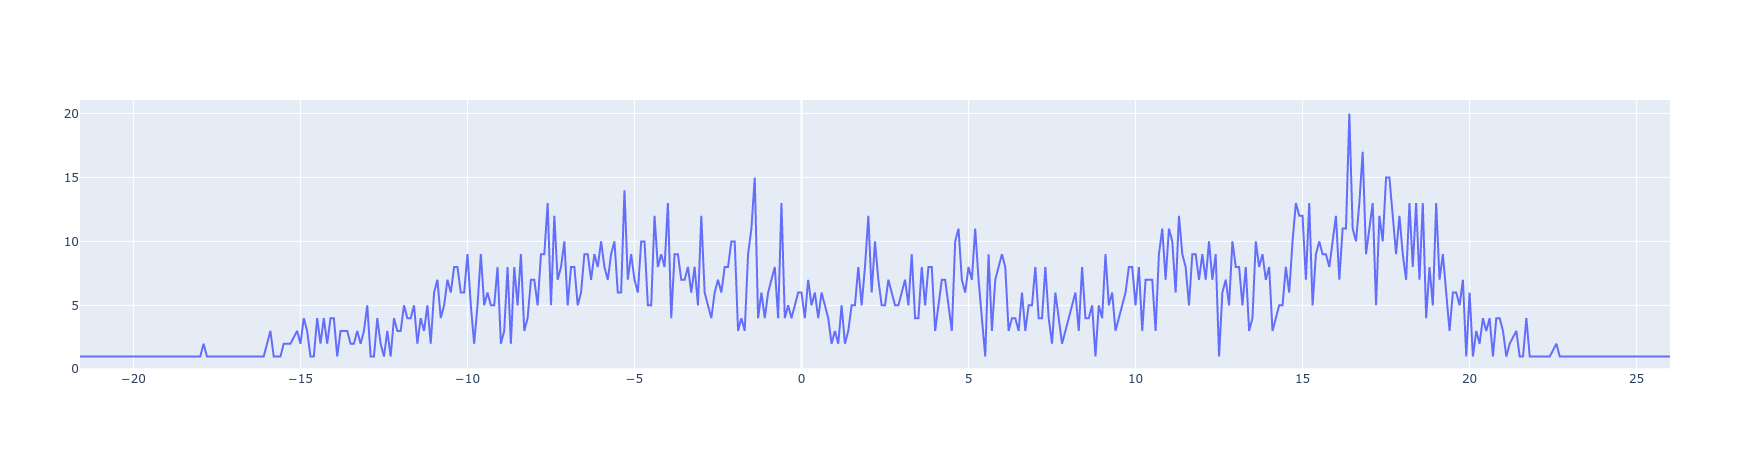

In [92]:
dic = {}
for i in y(get_data()):
    if i in dic:
        dic[i]+=1
    else:
        dic[i] = 1
plot(sorted(list(dic.items())))

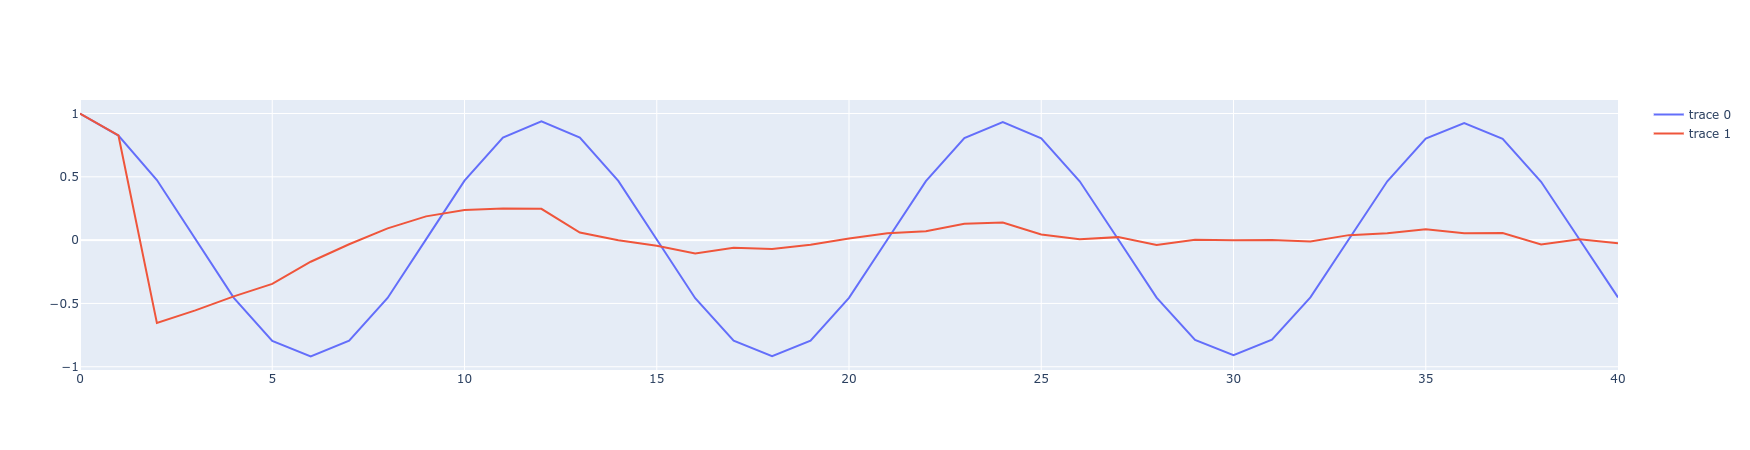

In [94]:
import statsmodels.tsa.stattools as st
def acfAnalyze(x):
    plot(enumerate(st.acf(x,fft=True)),enumerate(st.pacf(x)))

acfAnalyze(list(y(get_data())))

In [118]:
arr = np.array(list(y(get_data())))
@interact(w=w.IntSlider(min=12,max=120,step=12),w2=w.IntSlider(min=12+3,max=120,step=12))
def season_interact(w,w2):
    noseason = list(moving_window(enumerate(arr), window=w))
    season = arr[w//2:-(w//2-1)] - np.array(noseason).transpose()[1]
    plot(enumerate(season),noseason)
    mean_season = np.mean(np.hsplit(season,[12*i for i in range(1,len(season)//12+1)])[:-1], axis=0)
    plot(enumerate(np.tile(mean_season,3)))
    season_corr = arr[w//2:len(mean_season)*len(season)//12-len(arr)+1] - np.tile(mean_season, len(season)//12)
    plot(enumerate(season_corr))
    wghts = list(range(1,(w2+1)//2+1))+list(range(w2//2,0,-1))
    trendcyc = list(moving_window(enumerate(season_corr), window=w2, weights=wghts))
    plot(trendcyc)
    residual = season_corr[w2//2:-w2//2+1] - np.array(trendcyc).transpose()[1]
    plot(enumerate(residual))
    

interactive(children=(IntSlider(value=12, description='w', max=120, min=12, step=12), IntSlider(value=15, desc…

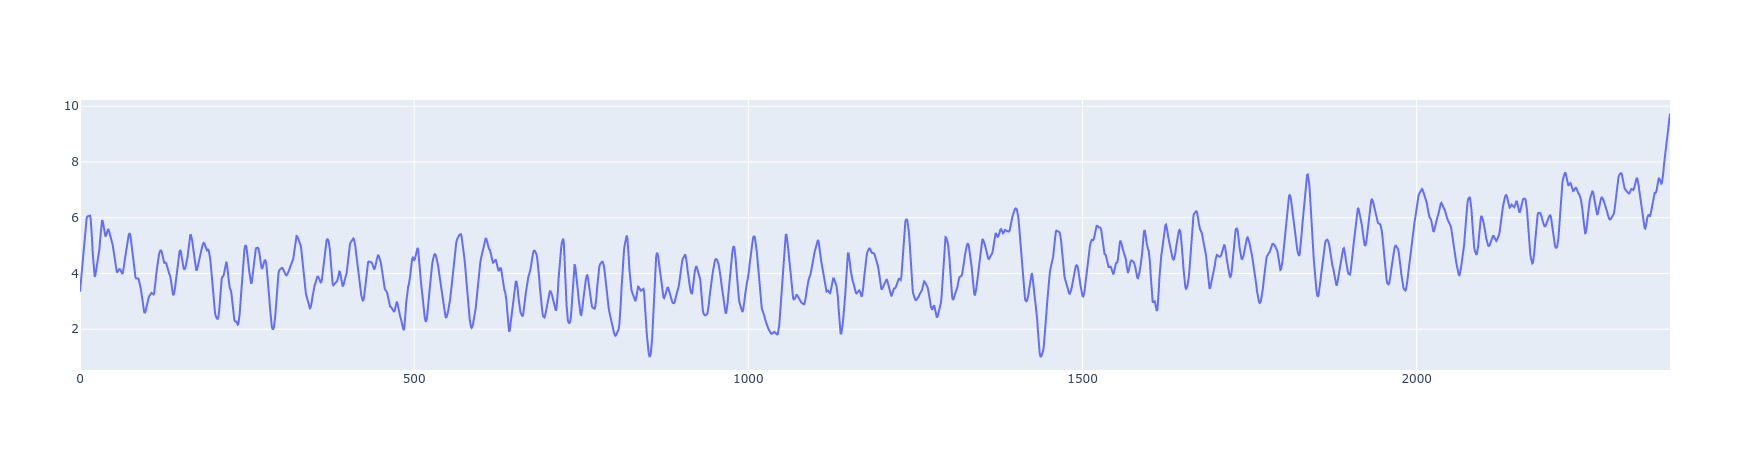

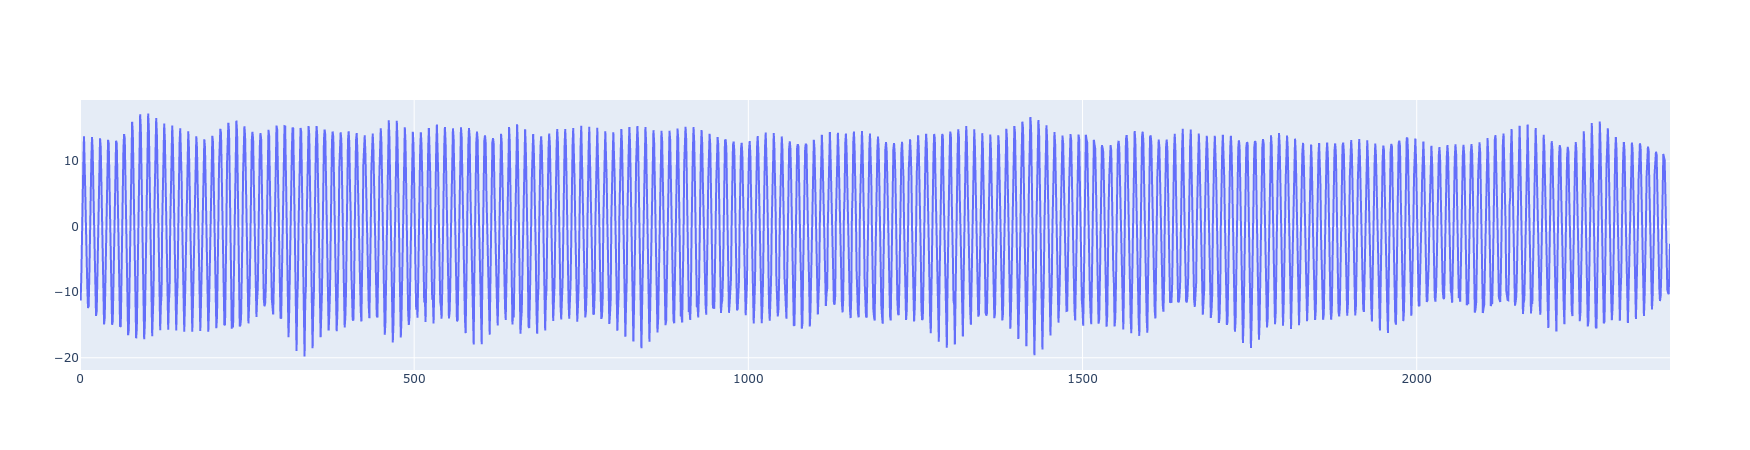

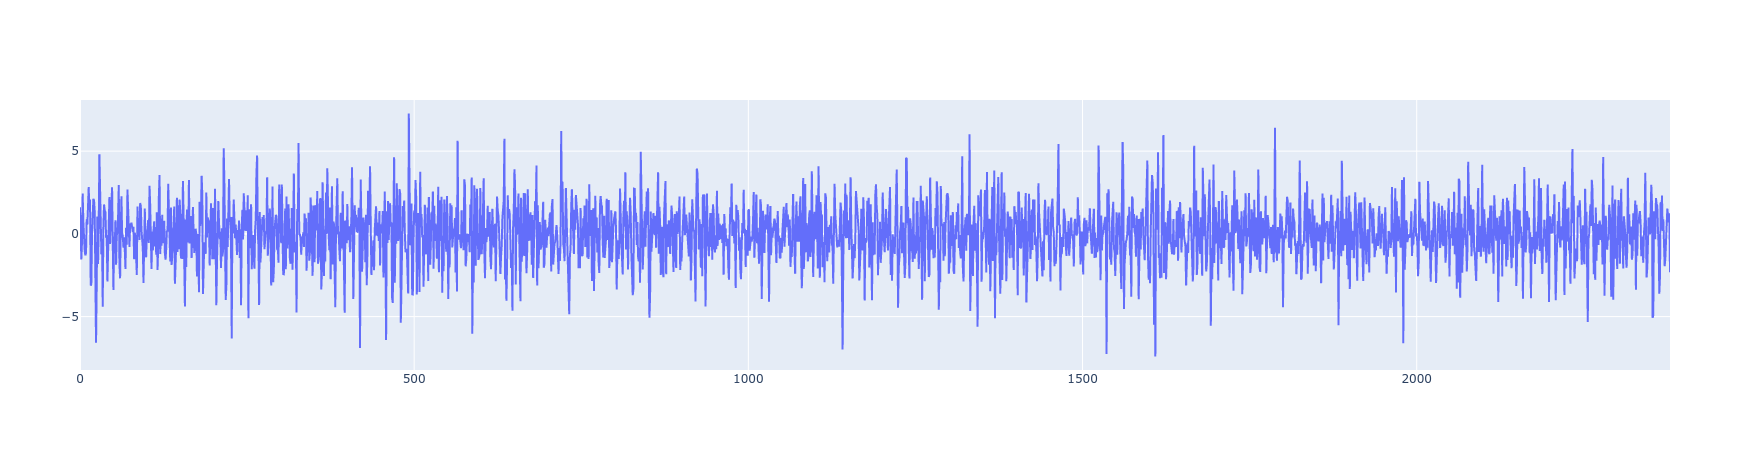

In [124]:
from statsmodels.tsa.seasonal import STL
stl = STL(np.array(list(y(get_data()))), period=12)
res = stl.fit()
plot(enumerate(res.trend))
plot(enumerate(res.seasonal))
plot(enumerate(res.resid))

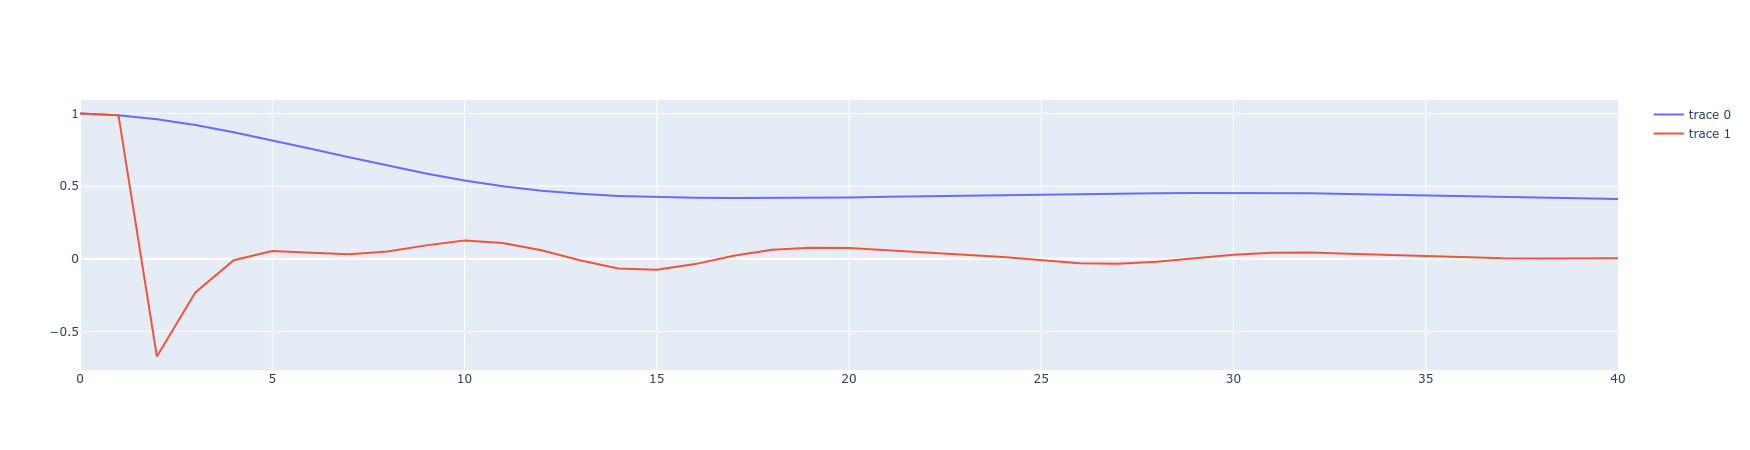

In [127]:
acfAnalyze(res.trend)

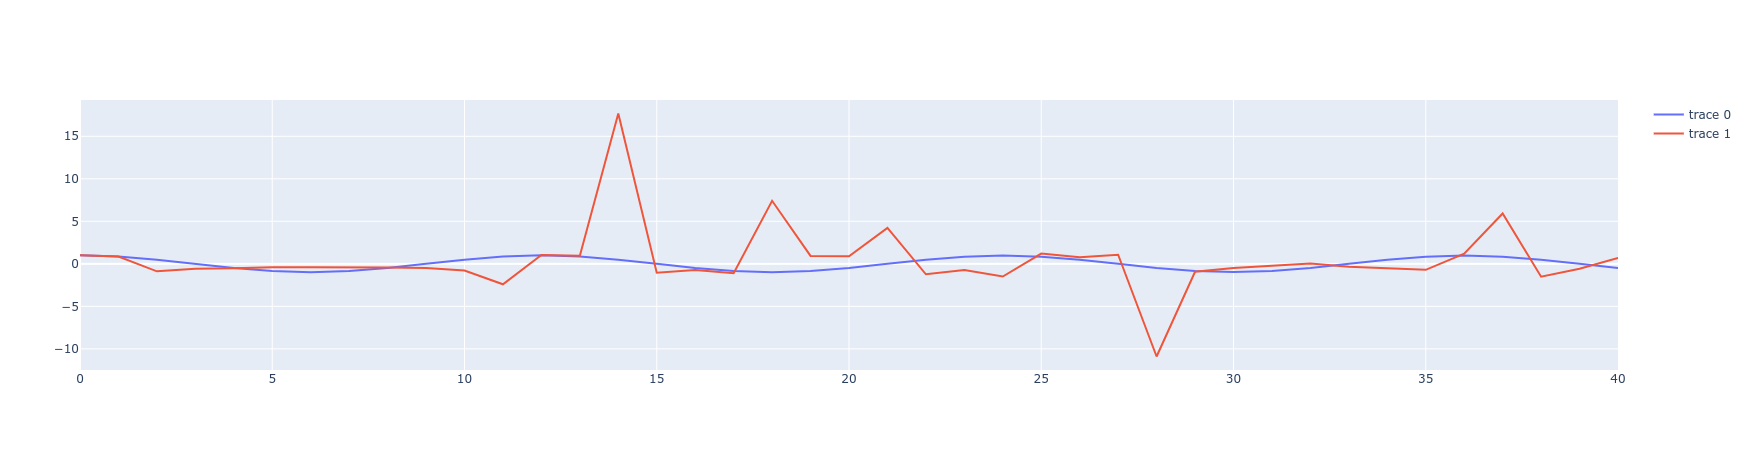

In [130]:
acfAnalyze(res.seasonal)

In [143]:
from statsmodels.tsa.arima.model import ARIMA

data = list(y(get_data()))
training_set = 12*100
training_data = data[:training_set]
test_data = data[training_set:]
model = ARIMA(training_data, order=(2,2,1), seasonal_order=(0,1,1,12))
fit = model.fit()

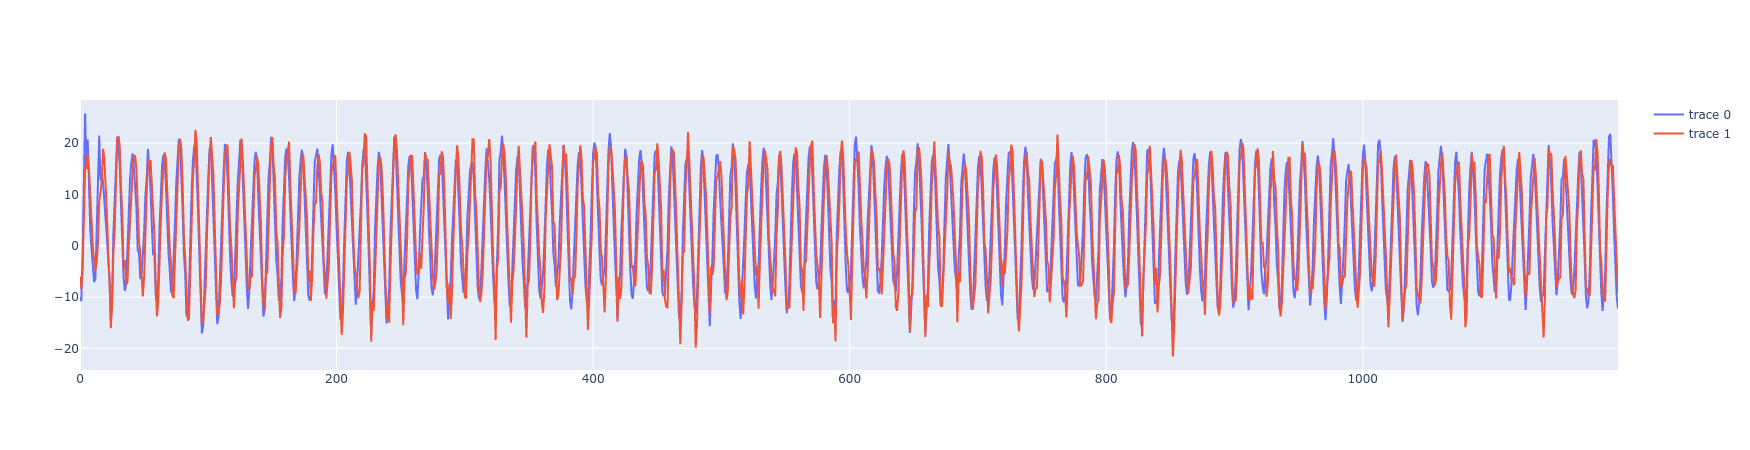

In [141]:
plot(enumerate(fit.predict(start=1,end=training_set)),enumerate(training_data))

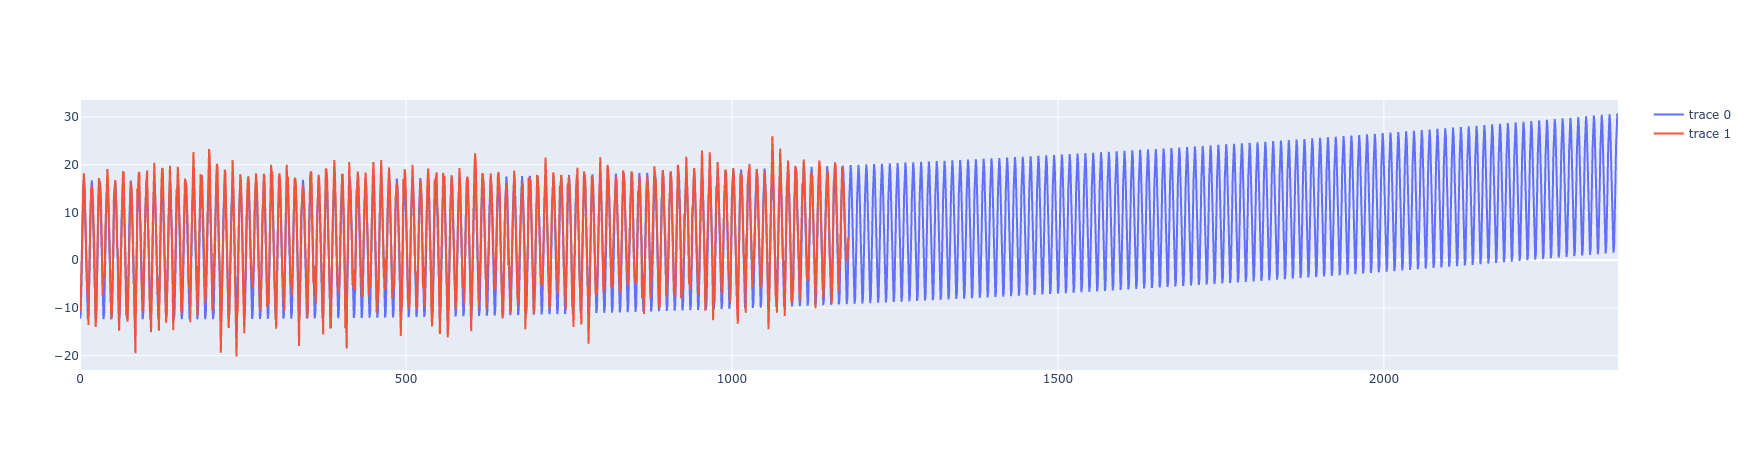

In [145]:
plot(enumerate(fit.forecast(len(test_data*2))), enumerate(test_data))

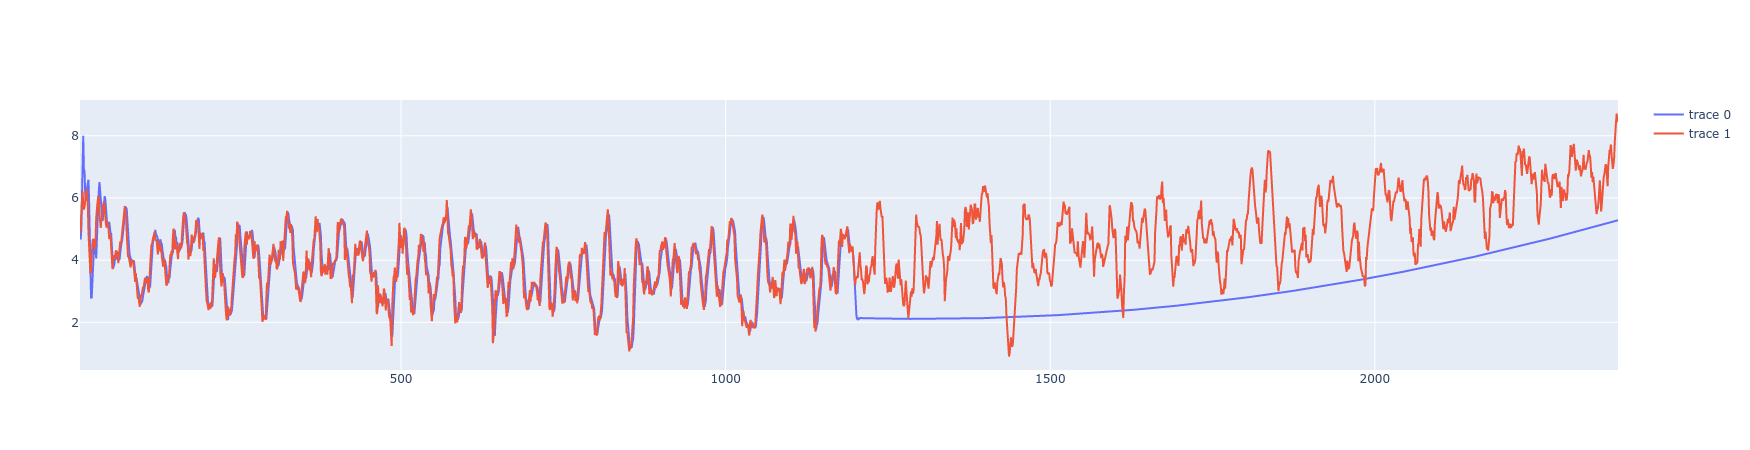

In [150]:
plot(moving_window(enumerate(fit.predict(start=0,end=len(data))),window=12), moving_window(enumerate(data),window=12))

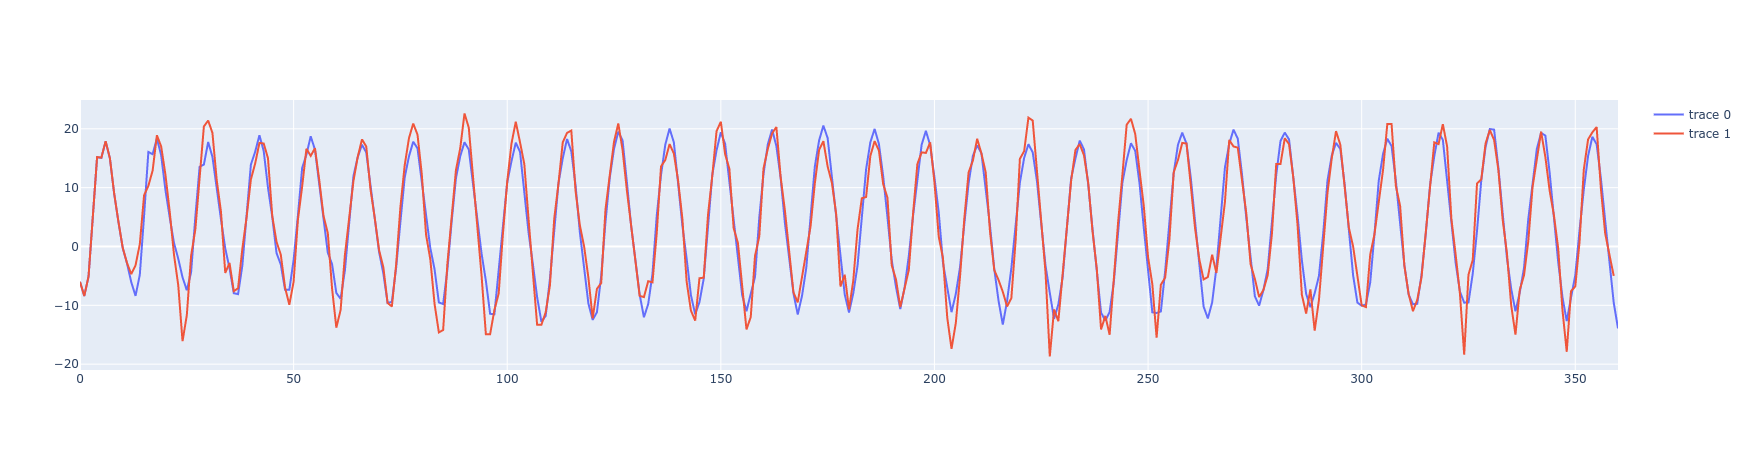

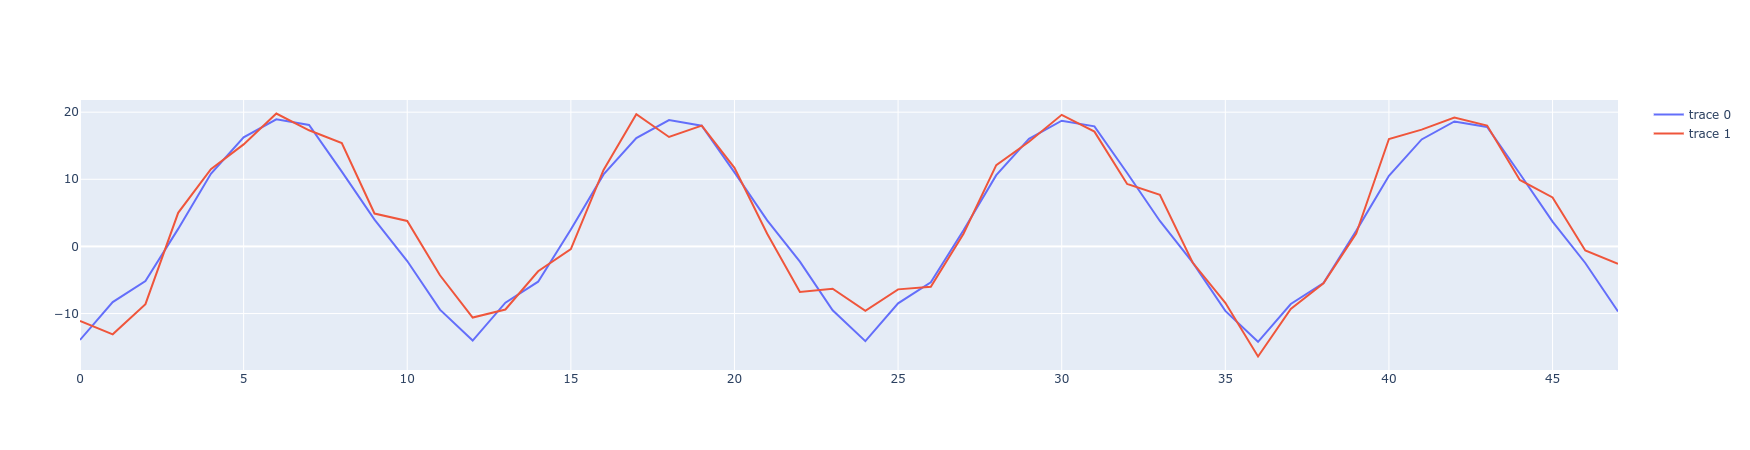

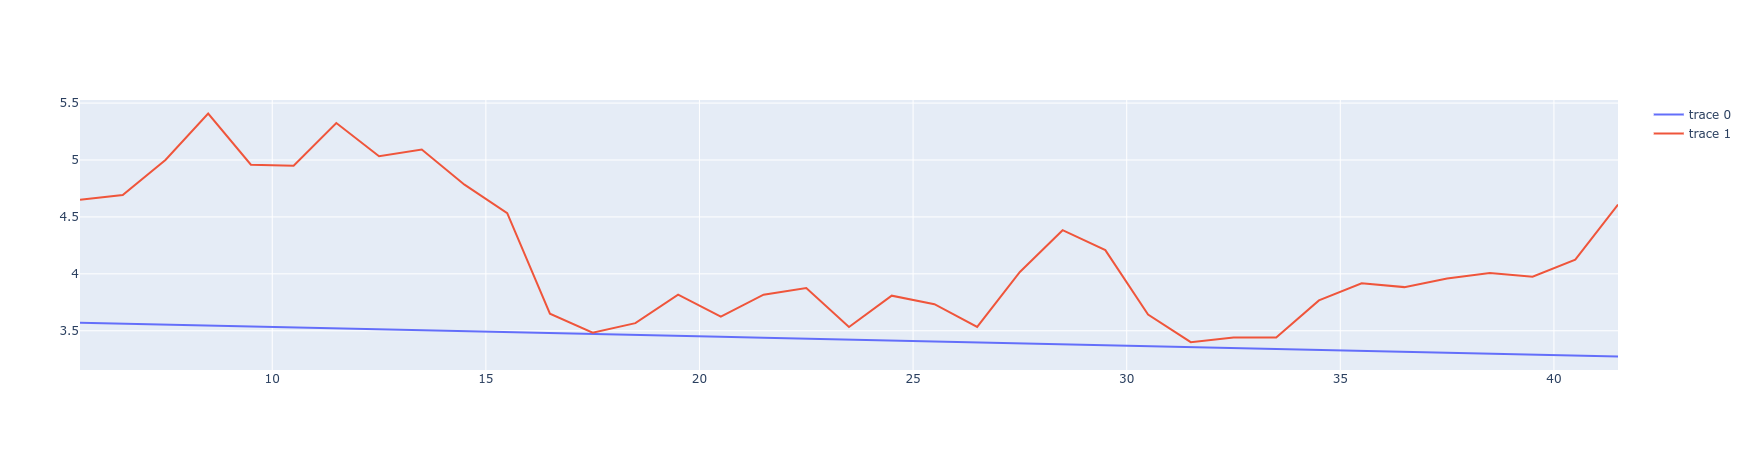

In [166]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def normalize(x):
    return np.log(x + 273.15)

def denorm(x):
    return np.exp(x)-273.15

data = normalize(np.array(list(y(get_data()))))
training_data_periods = 30
training_data_size = 12*training_data_periods
training_data=data[:training_data_size]
test_data=data[training_data_size:]

sm = ExponentialSmoothing(training_data, trend='mul', seasonal='add', seasonal_periods=12, damped=True)
res = sm.fit()
predict_periods=4
plot(enumerate(denorm(res.predict(0,training_data_size))), enumerate(denorm(training_data)))
plot(enumerate(denorm(res.forecast(predict_periods*12))), enumerate(denorm(test_data[:predict_periods*12])))
plot(moving_window(enumerate(denorm(res.forecast(predict_periods*12))),12), moving_window(enumerate(denorm(test_data[:predict_periods*12])),12))